### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [5]:
# Arxiv 
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

print(arxiv.invoke("Attention iss all you need"))

# Wikipedia
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

print(wiki.invoke("What is machine learning"))

arxiv
Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o
wikipedia
Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in p

In [6]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [10]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

print(tavily.invoke("Provide me the recent AI news for June 26th 2025? 5 bullet points only."))

[{'title': 'DDN Wins 2025 AI Breakthrough Award for AI Platform Innovation', 'url': 'https://www.ddn.com/press-releases/ddn-wins-2025-ai-breakthrough-award-for-ai-platform-innovation/', 'content': '# DDN Wins 2025 AI Breakthrough Award for AI Platform Innovation\n\nCHATSWORTH, Calif. – June 26, 2025 – DDN®, the global leader in AI and data intelligence solutions, today announced that it has been named winner of the “AI Platform Innovation Award” in the eighth annual AI Breakthrough Awards program, conducted by AI Breakthrough, a leading market intelligence organization that recognizes the top companies, technologies, and products in the global artificial intelligence industry.', 'score': 0.9296516}, {'title': 'AI Round-Up - June 2025 - Fladgate', 'url': 'https://www.fladgate.com/insights/ai-round-up-june-2025', 'content': 'Duolingo announced a sweeping transition to an "AI-first" business model, with CEO Luis von Ahn revealing that the language-learning platform will gradually phase ou

In [11]:
## Initialize my LLM model
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-qwq-32b")

### Combine all the tools in the list
tools=[arxiv , wiki, tavily, add, divide, multiply]

llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News?")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. Let me see which tools I can use here. The available functions are arxiv, wikipedia, tavily_search_results_json, add, divide, multiply. The arithmetic functions probably aren\'t relevant here. The arxiv function is for academic papers, which might include recent studies, but the user might be looking for more general news. The tavily_search_results_json function sounds like a search tool that could give current news. Wikipedia is for encyclopedic info, which might not be recent. \n\nSo, the best bet would be the tavily_search_results_json function since it\'s likely designed to fetch recent search results. I should call that with a query like "recent AI news" or "latest AI news updates". Let me format the tool call properly. The parameters require a "query" string. I\'ll set the query to "recent AI news 2023" to get the most up-to-date information. \n\nWait, does the function nee

In [14]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

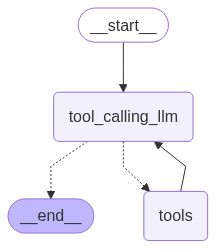

In [15]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}  # llm with bind tools

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [16]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me the top 5 recent AI news for June 26th 2025, add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 5 recent AI news for June 26th 2025, add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (8fxzhazmd)
 Call ID: 8fxzhazmd
  Args:
    query: top 5 recent AI news for June 26th 2025
  add (abp91fvj4)
 Call ID: abp91fvj4
  Args:
    a: 5
    b: 5
  multiply (z8aqztssc)
 Call ID: z8aqztssc
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Today's Top Tech & AI News at a Glance — June 26, 2025 - Medium", "url": "https://medium.com/simpletechdose/todays-top-tech-ai-news-at-a-glance-june-26-2025-d2518a0e729e", "content": "1. Microsoft and OpenAI dueling over artificial general intelligence  \nSummary: A report reveals tension in the Microsoft–OpenAI partnership: Microsoft wants OpenAI 

In [18]:
print(m.content)

Here’s the requested information:

---

### **Top 5 AI News (June 26th, 2025):**
1. **Microsoft-OpenAI Partnership Tensions**  
   - *Summary*: Microsoft wants OpenAI to remove a controversial clause that could restrict Microsoft’s access to future AGI developments. This dispute could impact the future of AI collaboration and monetization.  
   - Source: [Medium Article](https://medium.com/simpletechdose...)

2. **YouTube’s AI-Powered Search Carousel**  
   - *Summary*: YouTube Premium users now get AI-generated summaries and snippets via a new search carousel. While it speeds up content discovery, creators worry about reduced video views and ad revenue.  
   - Source: [TechCrunch via Medium](https://medium.com/simpletechdose...)

3. **Bosch CEO Warns Against Over-Regulation of AI in Europe**  
   - *Summary*: Bosch’s CEO argues that strict European AI regulations risk stifling innovation, even as the company invests millions in AI for industrial automation.  
   - Source: [Medium Arti

In [ ]:
messages = graph.invoke({"messages":HumanMessage(content="What is machine learning?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (c57z20tvr)
 Call ID: c57z20tvr
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message ==================================

Machine learning (ML) is a branch of a

### Agent Memory

In [20]:
messages = graph.invoke({"messages":HumanMessage(content="What is 5 plus 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 8
================================== Ai Message ==================================
Tool Calls:
  add (3ndekeqwd)
 Call ID: 3ndekeqwd
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: add

13
================================== Ai Message ==================================

The result of 5 plus 8 is **13**.


In [21]:
messages = [HumanMessage(content="Divide that by 5")]
messages = graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

To divide two numbers, I need the values for both a and b. Please provide the specific numbers you'd like to divide. For example: "Divide 20 by 5" or "What's 35 divided by 7?"


#### MemorySaver
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

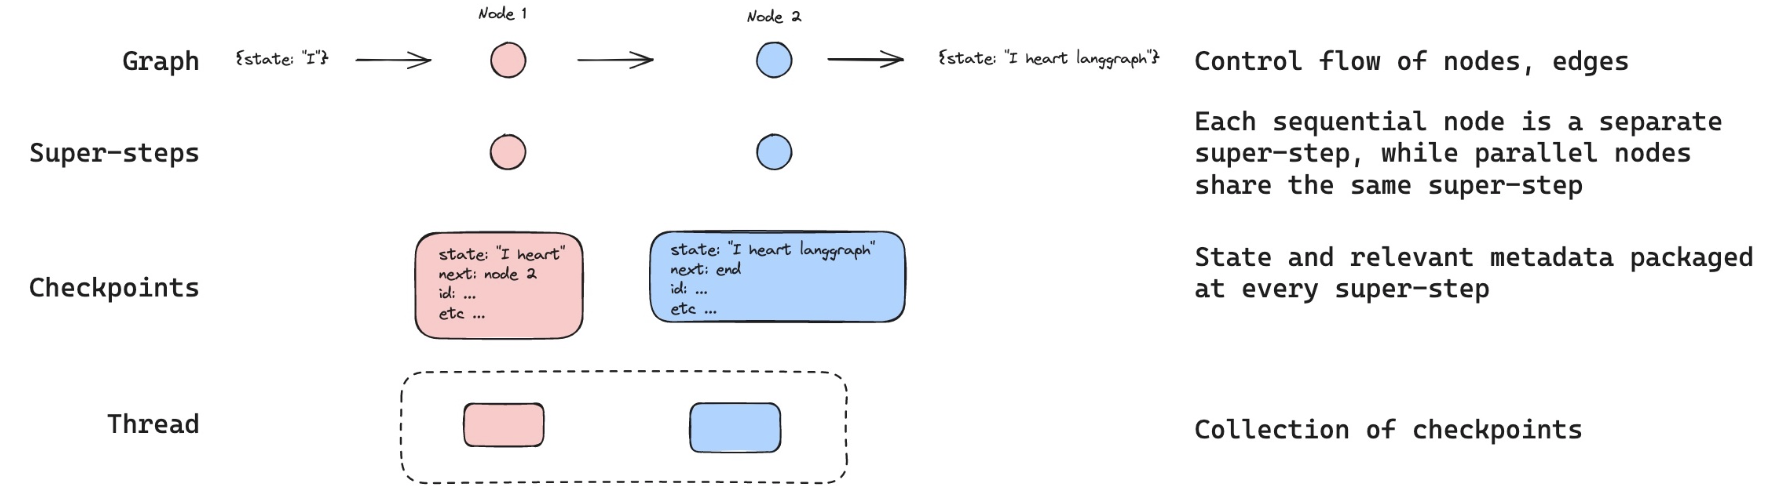

In [22]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o") 
llm_with_tools = llm.bind_tools(tools)

In [23]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

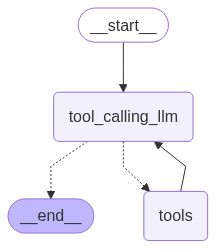

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [ ]:
## Specify the thread
config = {"configurable":{"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages = graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (call_3jfcLSbXFJ1HVOaSyUXFXel2)
 Call ID: call_3jfcLSbXFJ1HVOaSyUXFXel2
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.


In [26]:
messages = [HumanMessage(content="add that number to 25")]
messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (call_3jfcLSbXFJ1HVOaSyUXFXel2)
 Call ID: call_3jfcLSbXFJ1HVOaSyUXFXel2
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (call_LEirGrrkxMUufn9M0iwPWcf3)
 Call ID: call_LEirGrrkxMUufn9M0iwPWcf3
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

Adding 25 to the pr

In [27]:
messages = [HumanMessage(content="then multiplty that number by 2")]
messages = graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (call_3jfcLSbXFJ1HVOaSyUXFXel2)
 Call ID: call_3jfcLSbXFJ1HVOaSyUXFXel2
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is 25.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (call_LEirGrrkxMUufn9M0iwPWcf3)
 Call ID: call_LEirGrrkxMUufn9M0iwPWcf3
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

Adding 25 to the pr